In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline


Quantum state learning
======================

This demonstration works through the process used to produce the state
preparation results presented in `"Machine learning method for state
preparation and gate synthesis on photonic quantum
computers" <https://arxiv.org/abs/1807.10781>`__.

This tutorial uses the TensorFlow backend of Strawberry Fields, giving us access
to a number of
additional functionalities including: GPU integration, automatic gradient
computation, built-in optimization algorithms, and other machine
learning tools.

Variational quantum circuits
----------------------------

A key element of machine learning is optimization. We can use
TensorFlow's automatic differentiation tools to optimize the parameters
of variational quantum circuits constructed using Strawberry Fields. In
this approach, we fix a circuit architecture where the states, gates,
and/or measurements may have learnable parameters $\vec{\theta}$
associated with them. We then define a loss function based on the output
state of this circuit. In this case, we define a loss function such that
the fidelity of the output state of the variational circuit is maximized
with respect to some target state.

<div class="alert alert-info"><h4>Note</h4><p>For more details on the TensorFlow backend in Strawberry Fields, please see
    `machine_learning_tutorial`.</p></div>


For arbitrary state preparation using optimization, we need to make use
of a quantum circuit with a layer structure that is **universal** - that
is, by 'stacking' the layers, we can guarantee that we can produce *any*
CV state with at-most polynomial overhead. Therefore, the architecture
we choose must consist of layers with each layer containing
parameterized Gaussian *and* non-Gaussian gates. **The non-Gaussian
gates provide both the nonlinearity and the universality of the model.**
To this end, we employ the CV quantum neural network architecture as described in
`Killoran et al. <https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.1.033063>`__:

.. figure:: https://i.imgur.com/NEsaVIX.png
   :alt: layer

Here,

-  $\mathcal{U}_i(\theta_i,\phi_i)$ is an N-mode linear optical
   interferometer composed of two-mode beamsplitters
   $BS(\theta,\phi)$ and single-mode rotation gates
   $R(\phi)=e^{i\phi\hat{n}}$,

-  $\mathcal{D}(\alpha_i)$ are single mode displacements in the
   phase space by complex value $\alpha_i$,

-  $\mathcal{S}(r_i, \phi_i)$ are single mode squeezing operations
   of magnitude $r_i$ and phase $\phi_i$, and

-  $\Phi(\lambda_i)$ is a single mode non-Gaussian operation, in
   this case chosen to be the Kerr interaction
   $\mathcal{K}(\kappa_i)=e^{i\kappa_i\hat{n}^2}$ of strength
   $\kappa_i$.


Hyperparameters
---------------

First, we must define the **hyperparameters** of our layer structure:

-  ``cutoff``: the simulation Fock space truncation we will use in the
   optimization. The TensorFlow backend will perform numerical
   operations in this truncated Fock space when performing the
   optimization.

-  ``depth``: The number of layers in our variational quantum
   circuit. As a general rule, increasing the number of layers (and
   thus, the number of parameters we are optimizing over) increases the
   optimizer's chance of finding a reasonable local minimum in the
   optimization landscape.

-  ``reps``: the number of steps in the optimization routine performing
   gradient descent

Some other optional hyperparameters include:

-  The standard deviation of initial parameters. Note that we make a
   distinction between the standard deviation of *passive* parameters
   (those that preserve photon number when changed, such as phase
   parameters), and *active* parameters (those that introduce or remove
   energy from the system when changed).


In [2]:
import numpy as np

import strawberryfields as sf
from strawberryfields.ops import *
from strawberryfields.utils import operation

# Cutoff dimension
cutoff = 9

# Number of layers
depth = 15

# Number of steps in optimization routine performing gradient descent
reps = 200

# Learning rate
lr = 0.05

# Standard deviation of initial parameters
passive_sd = 0.1
active_sd = 0.001

The layer parameters $\vec{\theta}$
-----------------------------------------

We use TensorFlow to create the variables corresponding to the gate
parameters. Note that we focus on a single mode circuit where
each variable has shape ``(depth,)``, with each
individual element representing the gate parameter in layer $i$.



In [3]:
import tensorflow as tf

# set the random seed
tf.random.set_seed(42)

# squeeze gate
sq_r = tf.random.normal(shape=[depth], stddev=active_sd)
sq_phi = tf.random.normal(shape=[depth], stddev=passive_sd)

# displacement gate
d_r = tf.random.normal(shape=[depth], stddev=active_sd)
d_phi = tf.random.normal(shape=[depth], stddev=passive_sd)

# rotation gates
r1 = tf.random.normal(shape=[depth], stddev=passive_sd)
r2 = tf.random.normal(shape=[depth], stddev=passive_sd)

# kerr gate
kappa = tf.random.normal(shape=[depth], stddev=active_sd)

For convenience, we store the TensorFlow variables representing the
weights as a tensor:



In [4]:
weights = tf.convert_to_tensor([r1, sq_r, sq_phi, r2, d_r, d_phi, kappa])
weights = tf.Variable(tf.transpose(weights))

Since we have a depth of 15 (so 15 layers), and each layer takes
7 different types of parameters, the final shape of our weights
array should be $\text{depth}\times 7$ or ``(15, 7)``:



In [5]:
print(weights.shape)

(15, 7)


Constructing the circuit
------------------------

We can now construct the corresponding
single-mode Strawberry Fields program:



In [6]:
# Single-mode Strawberry Fields program
prog = sf.Program(1)

# Create the 7 Strawberry Fields free parameters for each layer
sf_params = []
names = ["r1", "sq_r", "sq_phi", "r2", "d_r", "d_phi", "kappa"]

for i in range(depth):
    # For the ith layer, generate parameter names "r1_i", "sq_r_i", etc.
    sf_params_names = ["{}_{}".format(n, i) for n in names]
    # Create the parameters, and append them to our list ``sf_params``.
    sf_params.append(prog.params(*sf_params_names))

``sf_params`` is now a nested list of shape ``(depth, 7)``, matching
the shape of ``weights``.



In [7]:
sf_params = np.array(sf_params)
print(sf_params.shape)

(15, 7)


Now, we can create a function to define the $i$\ th layer, acting on qumode ``q``. We add
the :class:`~strawberryfields.utils.operation` decorator so that the layer can be used as a single
operation when constructing our circuit within the usual Strawberry Fields Program context



In [8]:
# layer architecture
@operation(1)
def layer(i, q):
    Rgate(sf_params[i][0]) | q
    Sgate(sf_params[i][1], sf_params[i][2]) | q
    Rgate(sf_params[i][3]) | q
    Dgate(sf_params[i][4], sf_params[i][5]) | q
    Kgate(sf_params[i][6]) | q
    return q

Now that we have defined our gate parameters and our layer structure, we
can construct our variational quantum circuit.



In [9]:
# Apply circuit of layers with corresponding depth
with prog.context as q:
    for k in range(depth):
        layer(k) | q[0]

Performing the optimization
---------------------------

$\newcommand{ket}[1]{\left|#1\right\rangle}$ With the Strawberry
Fields TensorFlow backend calculating the resulting state of the circuit
symbolically, we can use TensorFlow to optimize the gate parameters to
minimize the cost function we specify. With state learning, the measure
of distance between two quantum states is given by the fidelity of the
output state $\ket{\psi}$ with some target state
$\ket{\psi_t}$. This is defined as the overlap between the two
states:

\begin{align}F = \left|\left\langle{\psi}\mid{\psi_t}\right\rangle\right|^2\end{align}

where the output state can be written
$\ket{\psi}=U(\vec{\theta})\ket{\psi_0}$, with
$U(\vec{\theta})$ the unitary operation applied by the variational
quantum circuit, and $\ket{\psi_0}=\ket{0}$ the initial state.

Let's first instantiate the TensorFlow backend, making sure to pass
the Fock basis truncation cutoff.



In [10]:
eng = sf.Engine("tf", backend_options={"cutoff_dim": cutoff})

Now let's define the target state as the single photon state
$\ket{\psi_t}=\ket{1}$:



In [11]:
import numpy as np

target_state = np.zeros([cutoff])
target_state[1] = 1
print(target_state)

[0. 1. 0. 0. 0. 0. 0. 0. 0.]


Using this target state, we calculate the fidelity with the state
exiting the variational circuit. We must use TensorFlow functions to
manipulate this data, as well as a ``GradientTape`` to keep track of the
corresponding gradients!

We choose the following cost function:

\begin{align}C(\vec{\theta}) = \left| \langle \psi_t \mid U(\vec{\theta})\mid 0\rangle - 1\right|\end{align}

By minimizing this cost function, the variational quantum circuit will
prepare a state with high fidelity to the target state.



In [12]:
def cost(weights):
    # Create a dictionary mapping from the names of the Strawberry Fields
    # free parameters to the TensorFlow weight values.
    mapping = {p.name: w for p, w in zip(sf_params.flatten(), tf.reshape(weights, [-1]))}

    # Run engine
    state = eng.run(prog, args=mapping).state

    # Extract the statevector
    ket = state.ket()

    # Compute the fidelity between the output statevector
    # and the target state.
    fidelity = tf.abs(tf.reduce_sum(tf.math.conj(ket) * target_state)) ** 2

    # Objective function to minimize
    cost = tf.abs(tf.reduce_sum(tf.math.conj(ket) * target_state) - 1)
    return cost, fidelity, ket

Now that the cost function is defined, we can define and run the
optimization. Below, we choose the Adam
optimizer that is built into TensorFlow:



In [13]:
opt = tf.keras.optimizers.Adam(learning_rate=lr)

We then loop over all repetitions, storing the best predicted fidelity
value.



In [14]:
fid_progress = []
best_fid = 0

for i in range(reps):
    # reset the engine if it has already been executed
    if eng.run_progs:
        eng.reset()

    with tf.GradientTape() as tape:
        loss, fid, ket = cost(weights)

    # Stores fidelity at each step
    fid_progress.append(fid.numpy())

    if fid > best_fid:
        # store the new best fidelity and best state
        best_fid = fid.numpy()
        learnt_state = ket.numpy()

    # one repetition of the optimization
    gradients = tape.gradient(loss, weights)
    opt.apply_gradients(zip([gradients], [weights]))

    # Prints progress at every rep
    if i % 1 == 0:
        print("Rep: {} Cost: {:.4f} Fidelity: {:.4f}".format(i, loss, fid))

Rep: 0 Cost: 0.9973 Fidelity: 0.0000
Rep: 1 Cost: 0.3459 Fidelity: 0.4297
Rep: 2 Cost: 0.5866 Fidelity: 0.2695
Rep: 3 Cost: 0.4118 Fidelity: 0.4013
Rep: 4 Cost: 0.5631 Fidelity: 0.1952
Rep: 5 Cost: 0.4099 Fidelity: 0.4547
Rep: 6 Cost: 0.2259 Fidelity: 0.6989
Rep: 7 Cost: 0.3996 Fidelity: 0.5248
Rep: 8 Cost: 0.1792 Fidelity: 0.7420
Rep: 9 Cost: 0.3776 Fidelity: 0.5674
Rep: 10 Cost: 0.2202 Fidelity: 0.6139
Rep: 11 Cost: 0.3579 Fidelity: 0.6167
Rep: 12 Cost: 0.3945 Fidelity: 0.5545
Rep: 13 Cost: 0.3199 Fidelity: 0.5458
Rep: 14 Cost: 0.1768 Fidelity: 0.6879
Rep: 15 Cost: 0.1306 Fidelity: 0.7587
Rep: 16 Cost: 0.1307 Fidelity: 0.7587
Rep: 17 Cost: 0.1232 Fidelity: 0.7906
Rep: 18 Cost: 0.2330 Fidelity: 0.8745
Rep: 19 Cost: 0.1836 Fidelity: 0.7759
Rep: 20 Cost: 0.1132 Fidelity: 0.7933
Rep: 21 Cost: 0.2029 Fidelity: 0.8302
Rep: 22 Cost: 0.0844 Fidelity: 0.8400
Rep: 23 Cost: 0.2028 Fidelity: 0.8303
Rep: 24 Cost: 0.0588 Fidelity: 0.8872
Rep: 25 Cost: 0.2228 Fidelity: 0.9060
Rep: 26 Cost: 0.1007 F

Results and visualisation
-------------------------

Plotting the fidelity vs. optimization step:



Text(0.5, 0, 'Step')

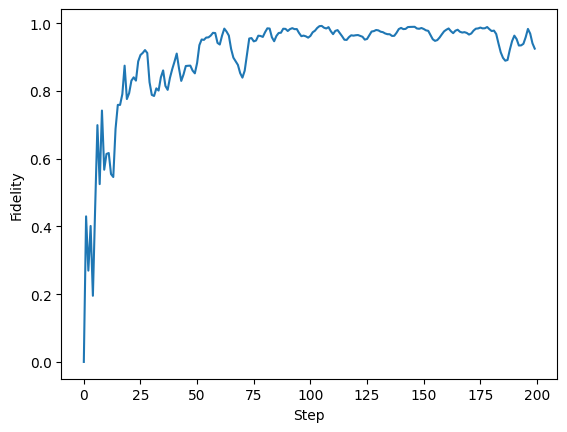

In [15]:
from matplotlib import pyplot as plt

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.sans-serif"] = ["Computer Modern Roman"]
plt.style.use("default")

plt.plot(fid_progress)
plt.ylabel("Fidelity")
plt.xlabel("Step")

We can use the following function to plot the Wigner function of our
target and learnt state:



In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def wigner(rho):
    """This code is a modified version of the 'iterative' method
    of the wigner function provided in QuTiP, which is released
    under the BSD license, with the following copyright notice:

    Copyright (C) 2011 and later, P.D. Nation, J.R. Johansson,
    A.J.G. Pitchford, C. Granade, and A.L. Grimsmo.

    All rights reserved."""
    import copy

    # Domain parameter for Wigner function plots
    l = 5.0
    cutoff = rho.shape[0]

    # Creates 2D grid for Wigner function plots
    x = np.linspace(-l, l, 100)
    p = np.linspace(-l, l, 100)

    Q, P = np.meshgrid(x, p)
    A = (Q + P * 1.0j) / (2 * np.sqrt(2 / 2))

    Wlist = np.array([np.zeros(np.shape(A), dtype=complex) for k in range(cutoff)])

    # Wigner function for |0><0|
    Wlist[0] = np.exp(-2.0 * np.abs(A) ** 2) / np.pi

    # W = rho(0,0)W(|0><0|)
    W = np.real(rho[0, 0]) * np.real(Wlist[0])

    for n in range(1, cutoff):
        Wlist[n] = (2.0 * A * Wlist[n - 1]) / np.sqrt(n)
        W += 2 * np.real(rho[0, n] * Wlist[n])

    for m in range(1, cutoff):
        temp = copy.copy(Wlist[m])
        # Wlist[m] = Wigner function for |m><m|
        Wlist[m] = (2 * np.conj(A) * temp - np.sqrt(m) * Wlist[m - 1]) / np.sqrt(m)

        # W += rho(m,m)W(|m><m|)
        W += np.real(rho[m, m] * Wlist[m])

        for n in range(m + 1, cutoff):
            temp2 = (2 * A * Wlist[n - 1] - np.sqrt(m) * temp) / np.sqrt(n)
            temp = copy.copy(Wlist[n])
            # Wlist[n] = Wigner function for |m><n|
            Wlist[n] = temp2

            # W += rho(m,n)W(|m><n|) + rho(n,m)W(|n><m|)
            W += 2 * np.real(rho[m, n] * Wlist[n])

    return Q, P, W / 2

Computing the density matrices
$\rho = \left|\psi\right\rangle \left\langle\psi\right|$ of the
target and learnt state,



In [17]:
rho_target = np.outer(target_state, target_state.conj())
rho_learnt = np.outer(learnt_state, learnt_state.conj())

Plotting the Wigner function of the target state:



C:\Users\mhakimi\AppData\Local\Temp\ipykernel_30592\1595207717.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


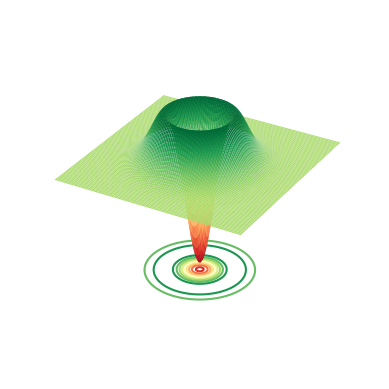

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
X, P, W = wigner(rho_target)
ax.plot_surface(X, P, W, cmap="RdYlGn", lw=0.5, rstride=1, cstride=1)
ax.contour(X, P, W, 10, cmap="RdYlGn", linestyles="solid", offset=-0.17)
ax.set_axis_off()
fig.show()

Plotting the Wigner function of the learnt state:



C:\Users\mhakimi\AppData\Local\Temp\ipykernel_30592\4117463628.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


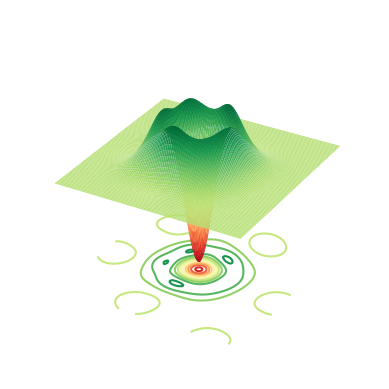

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
X, P, W = wigner(rho_learnt)
ax.plot_surface(X, P, W, cmap="RdYlGn", lw=0.5, rstride=1, cstride=1)
ax.contour(X, P, W, 10, cmap="RdYlGn", linestyles="solid", offset=-0.17)
ax.set_axis_off()
fig.show()

References
----------

1. Juan Miguel Arrazola, Thomas R. Bromley, Josh Izaac, Casey R. Myers,
   Kamil Brádler, and Nathan Killoran. Machine learning method for state
   preparation and gate synthesis on photonic quantum computers. `Quantum
   Science and Technology, 4
   024004 <https://iopscience.iop.org/article/10.1088/2058-9565/aaf59e>`__,
   (2019).

2. Nathan Killoran, Thomas R. Bromley, Juan Miguel Arrazola, Maria Schuld,
   Nicolas Quesada, and Seth Lloyd. Continuous-variable quantum neural networks.
   `Physical Review Research, 1(3), 033063.
   <https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.1.033063>`__,
   (2019).

